In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

from scipy.stats import pointbiserialr, kruskal, ttest_ind, f_oneway, shapiro, mannwhitneyu, levene
import pingouin as pg
import cloudpickle
import pickle

import warnings
warnings.filterwarnings('ignore')
from sklearn.neighbors import KNeighborsRegressor
import category_encoders as ce
import pickle
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from sklearn.decomposition import PCA
import os

In [2]:
def fImpReal(data, feature, alpha=0.05):
    print('Importance of variable', feature, '\n')
    x = data[feature]
    y = data['payroll_ind']
    
    x0 = x.loc[y==0]
    x1 = x.loc[y==1]
    
    lev = levene(x0, x1)
    if lev[1]<alpha:
        print('Variance Assumption Invalid: Test Results not Accurate')
    else:
        print('Variance Assumption Valid')
    
    s1 = shapiro(x0)[1]
    s2 = shapiro(x1)[1]
    if s1<alpha or s2<alpha:
        print('Normality Assumption Invalid: Test Results not Accurate\n')
    else:
        print('Normality Assumption Valid\n')
    
    pb = pointbiserialr(y, x)
    print('Point Biserial:', np.round(pb[0], 3))
    if pb[1]>alpha:
        print('Not Important')
    else:
        print('Important')
        
    ktest = kruskal(y, x, nan_policy='omit')
    print('Kruskal-Wallis H-test (No need for normality assumption):', np.round(ktest[0], 3))
    if ktest[1]>alpha:
        print('Not Important')
    else:
        print('Important')
        
    welch = ttest_ind(x0, x1, equal_var=False, nan_policy='omit')
    print('Welch t-Test (No need for variance assumption):', np.round(welch[0], 3))
    if welch[1]>alpha:
        print('Not Important')
    else:
        print('Important --> Checking post-hoc Games Howell test')
        gamesHowell = pg.pairwise_gameshowell(data=data, dv=feature, between='payroll_ind')
        if gamesHowell.iloc[0, :]['pval'] < alpha:
            print('Importance Confirmed')
        else:
            print('Importance Not Confirmed')
        
        
    mann = mannwhitneyu(x0, x1)
    print('Mann-Whitney U Test (No need for normality assumption):', np.round(mann[0], 3))
    if mann[1]>alpha:
        print('Not Important')
    else:
        print('Important')

def getTransactions(rem_act_no, bene_act_no):
    return train[(train['rem_act_no_dummy']==rem_act_no) & (train['bene_act_no_dummy']==bene_act_no)]

In [6]:
# groupDF = pd.read_csv('Data/groupDF_clean.csv', index_col=[0])
txnData = pd.read_csv('Data/train_data_txn.csv', index_col=0)

In [7]:
txnData

,rem_company_id_dummy,rem_act_no_dummy,bene_act_no_dummy,txn_amt,txn_type,payroll_ind,dd,comp_n_ind,rem_n_ind,bene_n_ind,...,bene_dd_diff,comp_txn_diff,rem_txn_diff,bene_txn_diff,time,rem_company_ind_0,rem_company_ind_1,rem_company_ind_2,rem_company_ind_3,rem_company_ind_4
txn_refr_key_dummy,,,,,,,,,,,,,,,,,,,,,
1,1000000000,5000000,8000000,1.458730,0,0,17,1,1,1,...,5.666667,0.945978,1.805991,0.021845,16,0,0,0,0,1
4,1000000020,5000200,8000200,1.269716,0,0,30,1,1,1,...,0.333333,0.593375,0.557836,-0.000794,29,0,0,0,1,0
5,1000000030,5000300,8000300,1.190682,0,0,22,1,1,1,...,0.000000,0.204006,0.204140,0.000000,21,0,0,0,1,1
7,1000000050,5000500,8000500,5.657271,0,0,29,1,1,1,...,10.857143,3.752990,4.461661,-0.296643,28,0,0,1,0,0
8,1000000020,5000200,8000600,1.239628,0,0,29,1,1,1,...,0.200000,0.623462,0.587924,0.011784,28,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3220108,1000000020,5000200,73649100,1.269388,0,0,29,1,1,1,...,0.000000,0.593702,0.558164,-0.090681,150,0,0,0,1,0
3220110,1000000020,5000200,74587700,1.594051,0,0,29,1,1,1,...,0.000000,0.269040,0.233502,0.000000,150,0,0,0,1,0
3220133,1000004320,5047800,9190600,1.328238,0,0,29,1,1,1,...,16.000000,-0.032856,-0.038370,-0.013997,58,0,0,1,1,0


In [13]:
# depCols = ['rem_txn_gap_diff', 'rem_dd_var_ratio', 'rem_n_ind', 'rem_dd_diff', 'rem_txn_diff']
# groupDF_clean = groupDF.drop(depCols, axis=1)

In [5]:
groupDF

,n_txn,payroll_ind,txn_amt_var,txn_amt_mean,txn_rate,txn_gap_mean,txn_gap_var,txn_per_day_mean,dd_mean,dd_var,...,bene_txn_per_day_ratio,comp_txn_gap_diff,comp_txn_gap_var_ratio,rem_txn_gap_var_ratio,txn_type_mean,rem_company_id_dummy,rem_company_ind_1,rem_company_ind_2,rem_company_ind_3,rem_company_ind_4
"(5000000, 8000000)",3,0,0.000954,1.480575,0.025641,58.500000,90.250000,1.0,11.333333,24.222222,...,1.0,-58.360720,321.093783,166.585267,0.0,0.037033,0,0,0,1
"(5000000, 8538500)",4,0,0.038843,1.337178,0.250000,5.333333,11.555556,1.0,11.000000,38.000000,...,1.0,-5.194053,41.112654,21.329477,0.0,0.037033,0,0,0,1
"(5000000, 8813800)",3,0,0.465905,1.553873,0.081081,18.500000,72.250000,1.0,15.666667,16.888889,...,1.0,-18.360720,257.052918,133.360504,0.0,0.037033,0,0,0,1
"(5000000, 9768200)",7,0,0.003921,1.081052,0.041667,28.000000,73.000000,1.0,21.285714,47.346939,...,1.0,-27.860720,259.721287,134.744869,0.0,0.037033,0,0,0,1
"(5000000, 9784300)",2,0,0.000000,1.218439,0.181818,11.000000,0.000000,1.0,9.500000,30.250000,...,1.0,-10.860720,0.000000,0.000000,0.0,0.037033,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(5742900, 74533500)",1,0,0.000000,2.727125,0.079409,35.575697,0.000000,1.0,26.000000,0.000000,...,1.0,-35.463677,0.000000,0.000000,0.0,-1.597808,0,0,1,1
"(5742900, 74564200)",1,0,0.000000,3.572418,0.079409,35.575697,0.000000,1.0,26.000000,0.000000,...,1.0,-35.463677,0.000000,0.000000,0.0,-1.597808,0,0,1,1
"(5743300, 74530200)",1,0,0.000000,1.054750,0.079409,35.575697,0.000000,1.0,26.000000,0.000000,...,1.0,-35.208857,29012.624030,20197.045874,1.0,0.000000,0,0,1,1
"(5743500, 74532600)",1,0,0.000000,7.023683,0.079409,35.575697,0.000000,1.0,26.000000,0.000000,...,1.0,-30.856947,0.000000,0.000000,1.0,4.195206,0,0,1,1


In [31]:
# X_pair = groupDF.drop('payroll_ind', axis=1)
# X_pair = groupDF_clean.drop('payroll_ind', axis=1)
X_pair = txnData.drop('payroll_ind', axis=1)

## Corrleation Heat Map

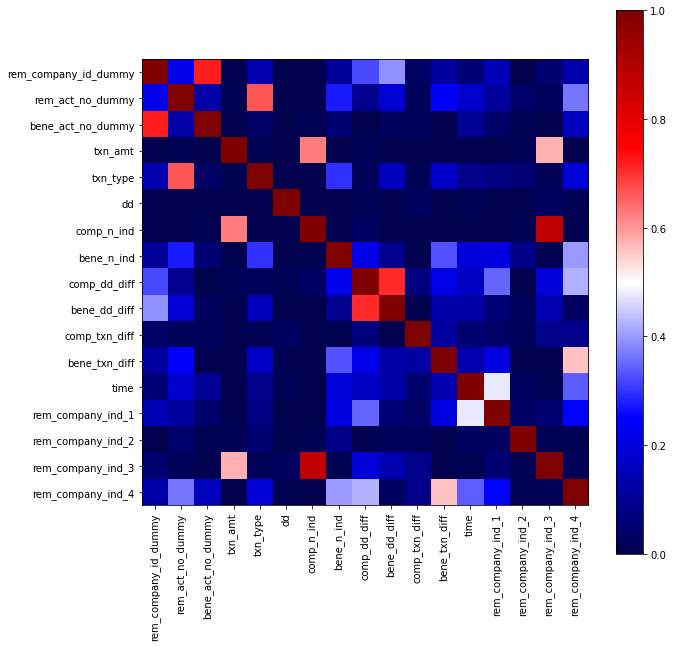

In [32]:
plt.figure(figsize=(10, 10))
fCorr = abs(X_pair.corr())
plt.imshow(fCorr.sort_index().sort_index(axis=1), cmap='seismic')
plt.colorbar()
plt.xticks(range(len(X_pair.columns)), X_pair.columns, rotation=90)
plt.yticks(range(len(X_pair.columns)), X_pair.columns)
plt.show()

## VIFs

In [33]:
vifs = []
cols = []
for i in range(len(X_pair.columns)):
    print(X_pair.columns[i], ' '*(18-len(X_pair.columns[i])), ':', np.round(VIF(X_pair.values, i), 4))
    vifs.append(VIF(X_pair.values, i))
    cols.append(X_pair.columns[i])

rem_company_id_dummy  : 8.4645
rem_act_no_dummy    : 12.2369
bene_act_no_dummy   : 3.2495
txn_amt             : 6.3708
txn_type            : 6.4245
dd                  : 6.6556
comp_n_ind          : 23.5188
bene_n_ind          : 4.629
comp_dd_diff        : 5.171
bene_dd_diff        : 3.8008
comp_txn_diff       : 5.2706
bene_txn_diff       : 1.6625
time                : 4.2351
rem_company_ind_1   : 1.1182
rem_company_ind_2   : 4.188
rem_company_ind_3   : 5.0297
rem_company_ind_4   : 2.7525


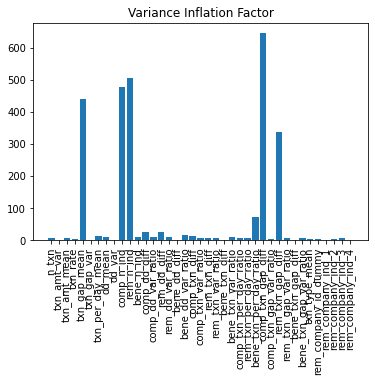

In [49]:
plt.bar(range(len(cols)), vifs)
plt.xticks(range(len(cols)), cols, rotation=90)
plt.title('Variance Inflation Factor')
plt.show()

In [52]:
print('Columns with vifs > 5')
count = 0
for i in range(len(cols)):
    if vifs[i]>10:
        count += 1
        print(cols[i], ' '*(18-len(X_pair.columns[i])), ':', vifs[i])

Columns with vifs > 5
txn_gap_mean        : 440.03466831945883
txn_per_day_mean    : 14.964460975777968
dd_mean             : 11.107090587877964
comp_n_ind          : 477.5406951501907
rem_n_ind           : 504.74931539923324
bene_n_ind          : 11.260287078201515
comp_dd_diff        : 26.19042704332961
rem_dd_diff         : 25.195935416422806
rem_dd_var_ratio    : 10.370124700377382
bene_dd_var_ratio   : 16.906836011357807
comp_txn_diff       : 11.929691534211312
bene_txn_per_day_ratio  : 73.79293549388123
comp_txn_gap_diff   : 645.6631654073027
rem_txn_gap_diff    : 337.420796277366


In [69]:
print('% of columns with VIF > 10 = {0}'.format(100*count/len(cols)))

% of columns with VIF > 10 = 35.8974358974359


## PCA

In [34]:
X_pairScaled = (X_pair - X_pair.mean())/X_pair.std()

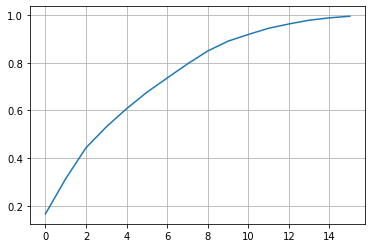

In [35]:
pca1 = PCA().fit(X_pairScaled.values)
pVarExp = [sum(pca1.explained_variance_[:i])/sum(pca1.explained_variance_) for i in range(1, len(X_pair.columns))]
plt.plot(pVarExp)
plt.grid()
plt.show()

In [36]:
dict(zip(range(1, 1+len(pVarExp)), pVarExp))

{1: 0.16639888083305143,
 2: 0.3140070051555127,
 3: 0.4436825589856558,
 4: 0.53098776038833,
 5: 0.6072713857083414,
 6: 0.6758997148480805,
 7: 0.7356826530819875,
 8: 0.7946197279822552,
 9: 0.8489718362057083,
 10: 0.8900328241356851,
 11: 0.918151697255363,
 12: 0.9440383415623368,
 13: 0.962182793274134,
 14: 0.9779060869456987,
 15: 0.9877761140105348,
 16: 0.9944555541386542}

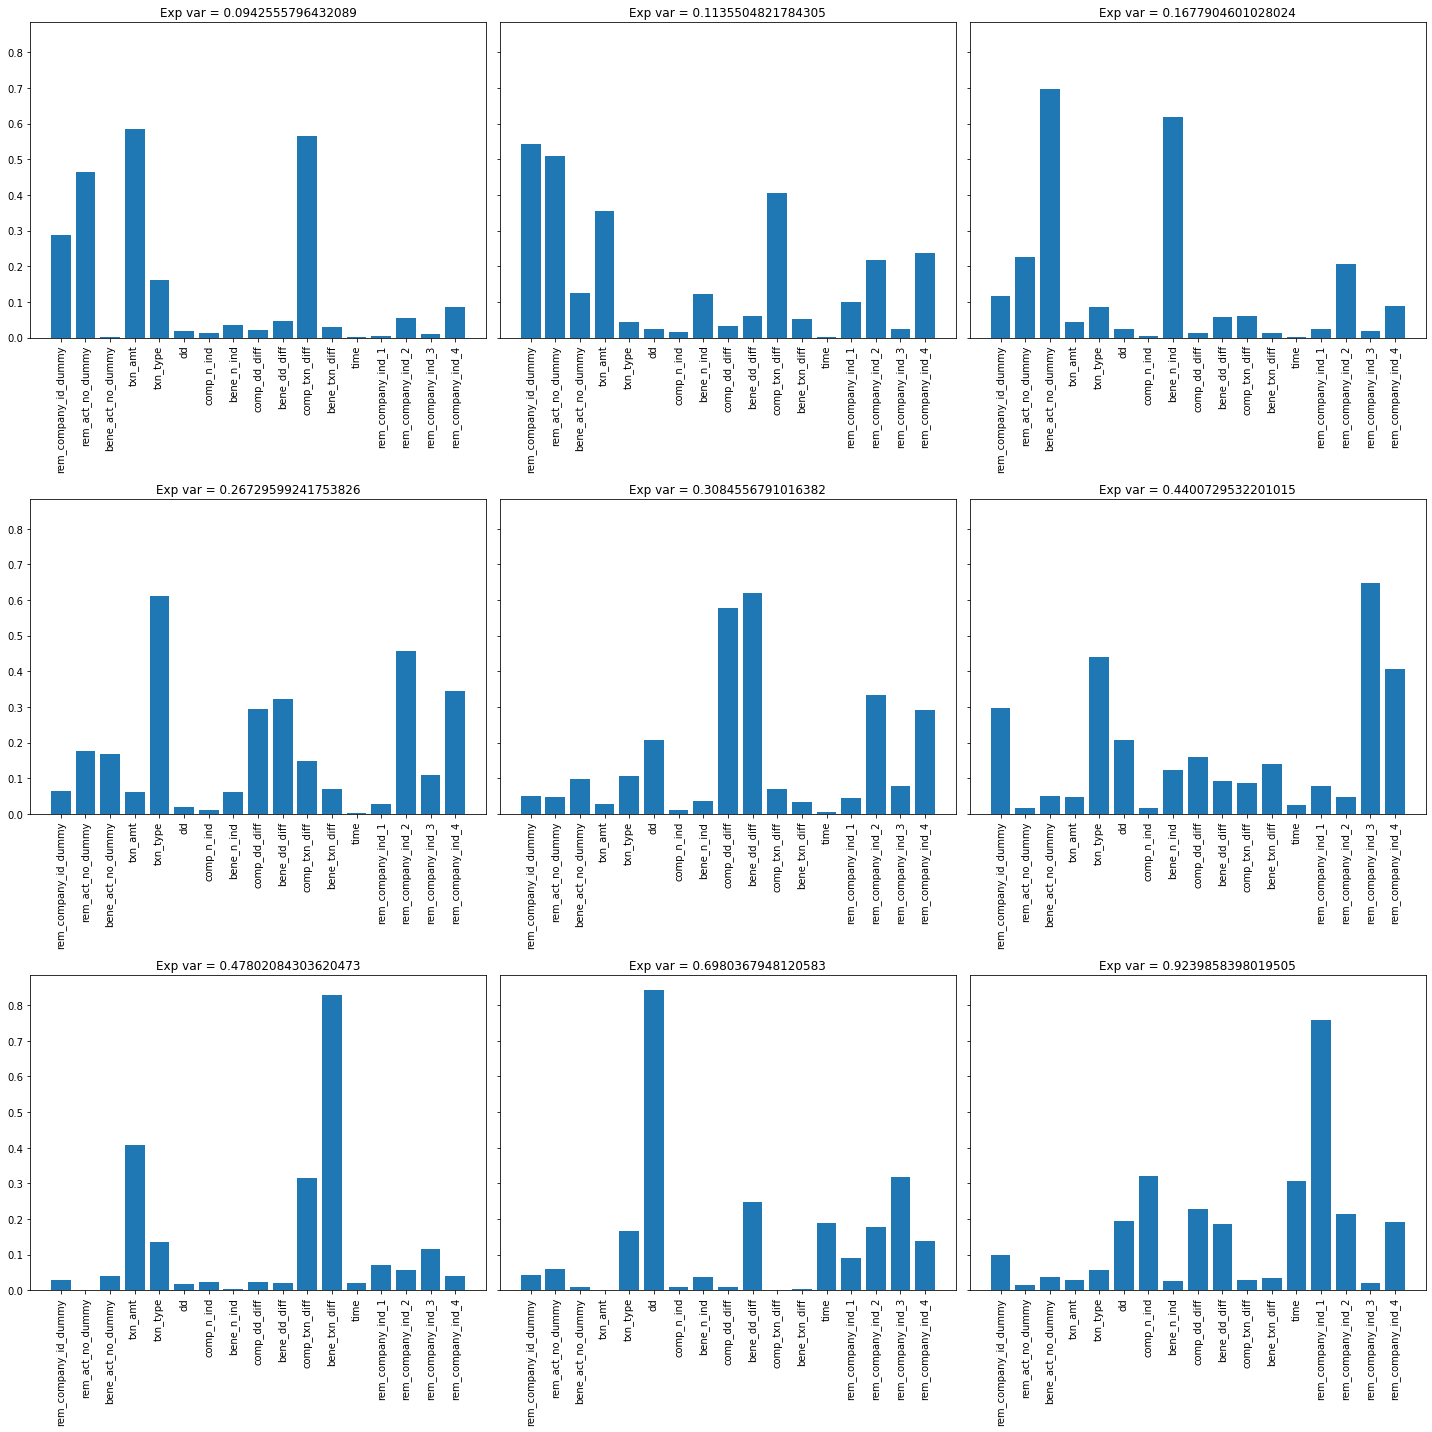

In [37]:
fig, ax = plt.subplots(3, 3, figsize=(20, 20), sharey=True)
i = 0
j = 0
for k in range(1, 10):
    
    ax[i][j].bar(range(len(X_pair.columns)), abs(pca1.components_[-k]))
    ax[i][j].set_xticks(range(len(X_pair.columns)))
    ax[i][j].set_xticklabels(X_pair.columns, rotation=90)
    ax[i][j].set_title('Exp var = {0}'.format(pca1.explained_variance_[-k]))
    j += 1
    if j==3:
        j = 0
        i += 1
plt.tight_layout()    
plt.show()

## Feature importance

In [38]:
for c in cols: #ignoring binary encoded columns
    print('----------------------Column: {0}----------------------'.format(c))
    fImpReal(txnData, c)

----------------------Column: rem_company_id_dummy----------------------
Importance of variable rem_company_id_dummy 

Variance Assumption Invalid: Test Results not Accurate
Normality Assumption Invalid: Test Results not Accurate

Point Biserial: 0.623
Important
Kruskal-Wallis H-test (No need for normality assumption): 1150840.971
Important
Welch t-Test (No need for variance assumption): -1268.476
Important --> Checking post-hoc Games Howell test
Importance Confirmed
Mann-Whitney U Test (No need for normality assumption): 2571090976.0
Important
----------------------Column: rem_act_no_dummy----------------------
Importance of variable rem_act_no_dummy 

Variance Assumption Invalid: Test Results not Accurate
Normality Assumption Invalid: Test Results not Accurate

Point Biserial: 0.685
Important
Kruskal-Wallis H-test (No need for normality assumption): 1228374.037
Important
Welch t-Test (No need for variance assumption): -1646.142
Important --> Checking post-hoc Games Howell test
Import

Kruskal-Wallis H-test (No need for normality assumption): 1231324.918
Important
Welch t-Test (No need for variance assumption): 108.322
Important --> Checking post-hoc Games Howell test
Importance Confirmed
Mann-Whitney U Test (No need for normality assumption): 66803685696.5
Important
----------------------Column: rem_company_ind_4----------------------
Importance of variable rem_company_ind_4 

Variance Assumption Invalid: Test Results not Accurate
Normality Assumption Invalid: Test Results not Accurate

Point Biserial: 0.211
Important
Kruskal-Wallis H-test (No need for normality assumption): 217146.571
Important
Welch t-Test (No need for variance assumption): -240.009
Important --> Checking post-hoc Games Howell test
Importance Confirmed
Mann-Whitney U Test (No need for normality assumption): 51863821389.5
Important


In [27]:
groupDF_clean.to_csv('Data/groupDF_clean.csv')